In [156]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from kalman_vect import plot_2d_gauss

We change notation for convinience 

$S = X$

$X = Z$

$\vec{X_{k+1}} = F\vec{X_{k}} + \vec{W}$

$\vec{Z_k} = H\vec{X_k} + \vec{V}$

$X_{k+1} = \begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \end{bmatrix}$
$F = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix}$
$H = \begin{bmatrix} 1 & 0 \\ 0 & 0\end{bmatrix}$

$W = N(0,Q)$

$V = N(0,R)$

Q and R are the covariances matrices

$\begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \end{bmatrix} = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix} \begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{W}$

${Z_k} = \begin{bmatrix} 1 & 0 \end{bmatrix}\begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{V}$

if $\dot{x_k} = 1$ and $\Delta{t} = 1$

Same problem

## Generative model

In [158]:
def generate_data(X_0 = np.array([0,1]), ):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-158-941514bd6d48>, line 2)

## Update (Multiplication or N dimensional normal pdfs)

https://www.cs.nyu.edu/~roweis/notes/gaussid.pdf

$N(c,C) = \alpha N(a,A)N(b,B) $

$ C = (A^{-1} + B^{-1})^{-1}$

$ c = CA^{-1}a + CB^{-1}b$

In [159]:
def gauss_pdfs_mult(a,A,b,B):
    A_1 = np.linalg.inv(A)
    B_1 = np.linalg.inv(B)
    C = np.linalg.inv(A_1 + B_1)
    c = C.dot(A_1).dot(a) + C.dot(B_1).dot(b)
    return c, C

### Example

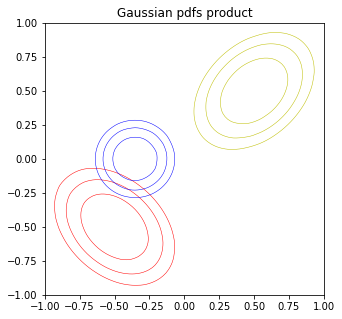

[-0.3535  0.    ]


In [162]:
plt.figure(figsize = (5,5))  

zero_mean = np.array([-0.5 , -0.5])
R = np.array([[1, -0.707],[0 ,1]])

mu_x = np.array([0.5 , 0.5])
sigma_x = np.array([[1, 0.707],[0 ,1]])
limit = 1
plot_2d_gauss(zero_mean, R, color='r', limits = [-limit,limit, -limit,limit])
plot_2d_gauss(mu_x, sigma_x, color='y', limits = [-limit,limit, -limit,limit])

mean, P = gauss_pdfs_mult(zero_mean, R, mu_x, sigma_x)
plot_2d_gauss(mean, P, color = 'b' , limits = [-limit,limit, -limit,limit])
plt.title('Gaussian pdfs product')
plt.show()
print(mean)

### Applied to our problem

$\vec{Z_k} = H\vec{X_k} + \vec{V}$

$\large{p(X_k|Z_k) = \alpha p(Z_k|X_k)p(X_K)}$

$a = \mu_{z_k} = Z \quad A = R \quad b=H\vec{\mu_{X_k}} \quad  B = H^T\Sigma_{X_k}H $ 

$C = \Sigma_{X_k}^{updated} \quad c=\vec{\mu_{X_k}}^{updated}$

$P_k = \Sigma_{X_k}^{ud} = (R^{-1} + \Sigma_{X_k}^{-1})^{-1}$

$\hat{X_k} = \vec{\mu_x^{ud}} = P_kR^{-1}Z+P_k\Sigma_{X_k}^{-1}\vec{\mu_{X_k}}$

In [4]:
def update(H, R, sigma_x, mu_x):
    H= np.array(H)
    return gauss_pdfs_mult(H.dot(mu_x), R, mu_x, sigma_x)

### Example: Position  is observed but speed is not observed

In [123]:
def plot_update(H, mu_x, sigma_x, R, y_offset = 0.1):
    plt.figure(figsize = (12,6))  
    mu_z = H.dot(mu_x)
    plot_2d_gauss(mu_x, sigma_x, limits = [-limit,3*limit, -limit+y_offset,limit+y_offset], color = 'r')
    plot_2d_gauss(mu_z, R, limits = [-limit,3*limit, -limit+y_offset,limit+y_offset], color = 'y')

    X_est, P = update(H, R, sigma_x, mu_x)
    plot_2d_gauss(X_est, P, limits = [-limit,3*limit, -limit+y_offset,limit+y_offset], color = 'b')
    return X_est, P

[ 0.   0.5]
[[ 0.83333333  0.        ]
 [ 0.          4.97512438]]


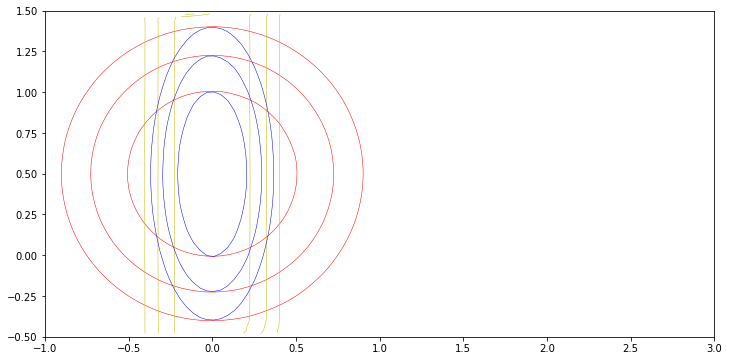

In [163]:
initial_speed_guess = 0.5
H = np.array([[1, 0],[0,1]])
# a priori estimates
mu_x = np.array([0 , initial_speed_guess])
sigma_x = np.array([[5, 0],[0 ,5]])

# I quite know my position but not my speed then variance -> infinite
R = np.array([[1, 0],[0 ,1000]])

mu_x_u, sigma_x_u = plot_update(H, mu_x, sigma_x, R, y_offset = initial_speed_guess)
print(mu_x_u)
print(sigma_x_u)

## Prediction (Independent random vectors linear combination)

$E[A\vec{X} + \vec{Y}] = AE[\vec{X}]+E[\vec{Y}]$

$\Sigma_{AX+Y} = A\Sigma_{X}A^T + \Sigma_{Y}$

### Applied

$\vec{X_{k+1}} = F\vec{X_{k}} + \vec{W}$

$\hat{\vec{X_{k+1}}} = F\hat{\vec{X_{k}}}$

$P_{k+1} = F\Sigma_{X}F^T + Q$

$\begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \end{bmatrix} = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix} \begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{W}$

$\hat{x_{k+1}} = \hat{x_{k}} + \Delta t \dot{X_k}$

In [28]:
def predict(F, mu_x, sigma_x, Q):
    X_est = F.dot(mu_x)
    P = F.dot(sigma_x).dot(F.T) + Q
    return X_est, P

[[1 1]
 [0 1]]
[ 0.5  0.5]


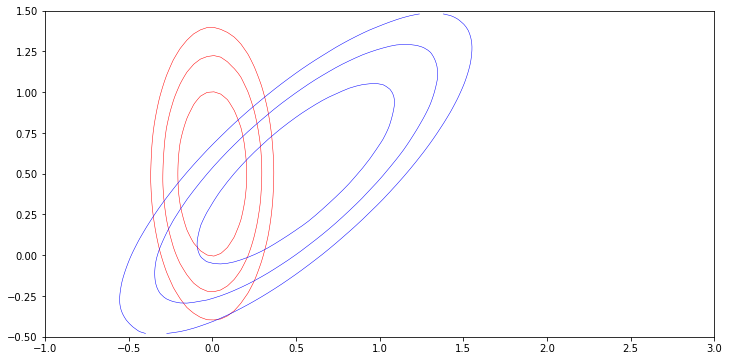

In [126]:
def plot_prediction(F, mu_x, sigma_x, Q, y_offset = 0.1):
    mu_w = np.array([0,0])
    plt.figure(figsize = (12,6))  
    plot_2d_gauss(mu_x, sigma_x, limits = [-limit,3*limit, -limit+y_offset,limit+y_offset], color = 'r')
    #plot_2d_gauss(mu_w, Q, limits = [-limit,3*limit, -limit+y_offset,limit+y_offset], color = 'y')

    mu_x, sigma_x = predict(F, mu_x, sigma_x, Q)
    plot_2d_gauss(mu_x, sigma_x, limits = [-limit,3*limit, -limit+y_offset,limit+y_offset], color = 'b')
    return mu_x, sigma_x

#sigma_x = np.array([[1, 0],[0 ,10000]])

F = np.array([[1, 1],[0,1]])
print(F)
# speed variance = infinite
Q = np.array([[1, 0],[0 , 1]])

mu_x_p, sigma_x_p  = plot_prediction(F, mu_x_u, sigma_x_u, Q, y_offset = initial_speed_guess)
print(mu_x_p)

[ 0.5  0.5]


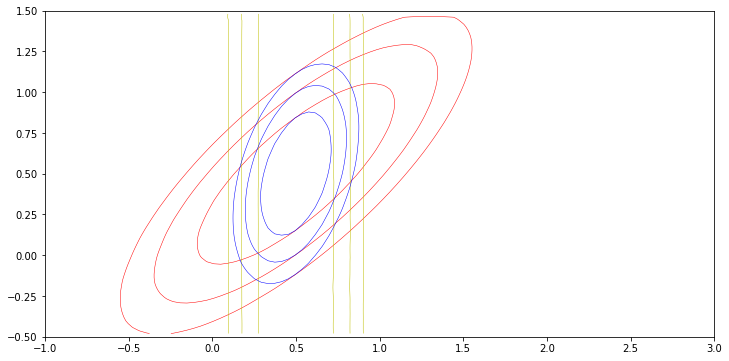

In [127]:
mu_x_uu, sigma_x_uu = plot_update(H, mu_x_p, sigma_x_p, R,y_offset = initial_speed_guess)
print(mu_x_uu)

[ 1.   0.5]


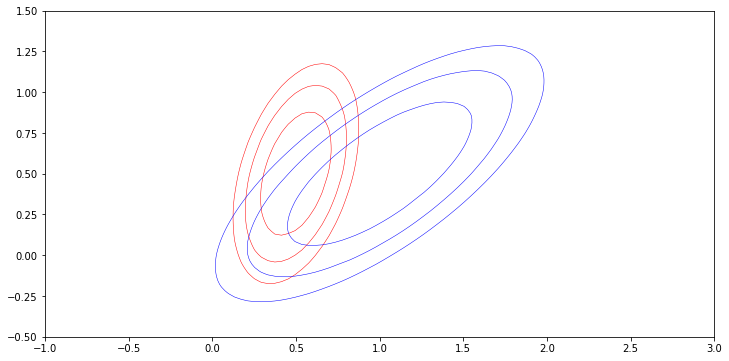

In [128]:
mu_x_pp, sigma_x_pp  = plot_prediction(F, mu_x_uu, sigma_x_uu, Q, y_offset = initial_speed_guess)
print(mu_x_pp)

[ 0.5  0.5]


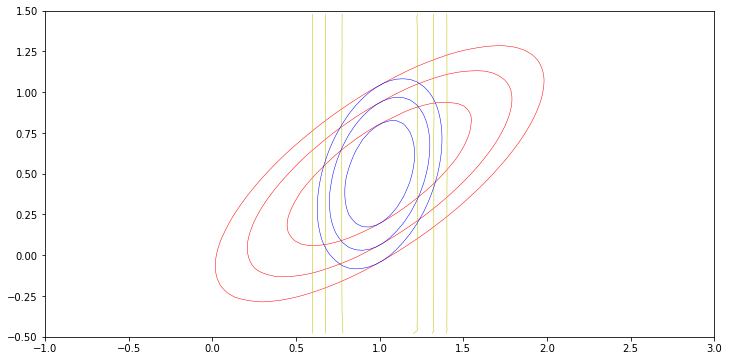

In [129]:
mu_x_uuu, sigma_x_uuu = plot_update(H, mu_x_pp, sigma_x_pp, R,y_offset = initial_speed_guess)
print(mu_x_uu)

$\begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \end{bmatrix} = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix} \begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{W}$

${Z_k} = \begin{bmatrix} 1 & 0 \end{bmatrix}\begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{V}$

In [218]:
def update(H, R, sigma_x, mu_x):
    H= np.array(H)
    return gauss_pdfs_mult(H.dot(mu_x), R, mu_x, sigma_x)

def gauss_pdfs_mult(a,A,b,B):
    # Hay que ver que pasa si A es escalar para el caso de no observar la velocidad
    if type(a) is not np.ndarray:
        A_1 = 1/A
    else:
        A_1 = np.linalg.inv(A)
    print(A_1)
    B_1 = np.linalg.inv(B)
    C = np.linalg.inv(A_1 + B_1)
    c = C.dot(A_1).dot(a) + C.dot(B_1).dot(b)
    return c, C

In [221]:
H = np.array([[1, 0],[0,1]])
#H = np.array([1, 0])
print(H.shape)
# a priori estimates
mu_x = np.array([0.1 , 0.1])
R = np.array([[1, 0],[0, 10000]])
#R = 1

mu_x, sigma_x = update(H, R, sigma_x, mu_x)
print(mu_x)

(2, 2)
[[  1.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-04]]
[ 0.1  0.1]


In [220]:
[[ 0.09558081  0.08169192]
 [ 0.08169192  0.09558081]]

SyntaxError: invalid syntax (<ipython-input-220-7c270b881991>, line 1)

In [ ]:
sigma_x = np.array([[5, 0],[0 ,5]])

R = np.array([[1, 0],[0, 1]])
Q = np.array([[1, 0],[0, 1]])
F = np.array([[1, 1],[0, 1]])

#print(update(H, R, sigma_x, mu_x))
#plot_update(H, mu_x, sigma_x, R, y_offset = 0.1)
for i in range(1):
    print(mu_x)
    #print(sigma_x[0,0])
    mu_x, sigma_x = update(H, R, sigma_x, mu_x)
    print(mu_x)
    #mu_x, sigma_x = predict(F, mu_x, sigma_x, Q)
    #print(mu_x)